In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from figurefirst import FigureLayout,mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

In [9]:
# Define the generator model
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.model(x)

# Define the discriminator model
# class Discriminator(nn.Module):
    # def __init__(self, input_size, hidden_size=128):
    #     super(Discriminator, self).__init__()
    #     self.model = nn.Sequential(
    #         nn.Linear(input_size, hidden_size),
    #         nn.ReLU(),
    #         nn.Linear(hidden_size, hidden_size),
    #         nn.ReLU(),
    #         nn.Linear(hidden_size, 1),
    #         nn.Sigmoid(),
    #     )

    # def forward(self, x):
    #     return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the GAN model
class GAN(nn.Module):
    def __init__(self, input_size_g, output_size_g, input_size_d, hidden_size_d=128):
        super(GAN, self).__init__()
        self.generator = Generator(input_size_g, output_size_g)
        self.discriminator = Discriminator(input_size_d, hidden_size_d)

    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x
    
# Custom dataset class
class OdorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data.iloc[idx][["xsrc", "ysrc", "odor", "corrected_u", "corrected_v"]]
        return torch.tensor(sample.values, dtype=torch.float32)

In [10]:
# dir = '~/DataAnalysis/data/Sprints/HighRes/'
# data = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5') 

In [11]:
dir='~/DataAnalysis/data/puff_data/'
data=pd.read_hdf(dir+'puff_data_wc.h5') 

In [8]:
data

,time,x,y,odor,windx,windy
0,0.0000,-1.003679,1.522490,0.0,4.000000e-01,0.0
1,0.0001,3.605714,-2.164526,0.0,4.000000e-01,0.0
2,0.0002,1.855952,-7.913990,0.0,4.000000e-01,0.0
3,0.0003,0.789268,0.977404,0.0,4.000000e-01,0.0
4,0.0004,-2.751851,6.345127,0.0,4.000000e-01,0.0
...,...,...,...,...,...,...
999995,99.9995,3.104647,-0.630729,0.0,2.449294e-17,0.4
999996,99.9996,-0.501450,6.482567,0.0,2.449294e-17,0.4
999997,99.9997,-0.655424,2.929773,0.0,2.449294e-17,0.4
999998,99.9998,-0.570630,-2.581455,0.0,2.449294e-17,0.4


In [13]:
# Replace with your data file

new_data=data[:700000]

dataset = OdorDataset(new_data)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=4)

# Initialize GAN, optimizer, and loss function
input_size_g = 4  # xsrc, ysrc, wind_velocity_U, and wind_velocity_V
output_size_g = 1  # New odor measurement
input_size_d = 5  # xsrc, ysrc, odor, wind_velocity_U, and wind_velocity_V

gan = GAN(input_size_g, output_size_g, input_size_d)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gan.to(device)
optimizer = optim.Adam(gan.parameters(), lr=0.00002)
criterion = nn.BCEWithLogitsLoss()
scaler = GradScaler()

## Train GAN
num_epochs = 50
for epoch in range(num_epochs):
    for i, real_data in enumerate(dataloader):
        real_data = real_data.to(device)
        input_gen = real_data[:, [0, 1, 3, 4]]

        with autocast():
            generated_odor = gan.generator(input_gen)
            fake_data = torch.cat((input_gen[:, :2], generated_odor, input_gen[:, 2:]), dim=1)

            real_labels = torch.ones(real_data.size(0), 1).to(device)
            fake_labels = torch.zeros(fake_data.size(0), 1).to(device)

            real_outputs = gan.discriminator(real_data)
            real_loss = criterion(real_outputs, real_labels)

            fake_outputs = gan.discriminator(fake_data.detach())
            fake_loss = criterion(fake_outputs, fake_labels)

            d_loss = real_loss + fake_loss

        scaler.scale(d_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        with autocast():
            fake_outputs = gan.discriminator(fake_data)
            g_loss = criterion(fake_outputs, real_labels)

        scaler.scale(g_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')
#         fixed_noise = torch.randn(30, input_size_g).to(device)
#         generated_samples = gan.generator(fixed_noise).detach().cpu().numpy()
#         print(generated_samples)

In [90]:
t_data=data[500000:700000]

test_data = torch.tensor([
    t_data.xsrc.values,
    t_data.ysrc.values,
    t_data.corrected_u.values,
    t_data.corrected_v.values
], dtype=torch.float32).T  # Transpose to have the correct shape



test_data = test_data.to(device) 
generated_odor = gan.generator(test_data)

# Convert generated odor to NumPy array

generated_odor_np = generated_odor.detach().cpu().numpy()

In [94]:
x = generated_odor_np/5000

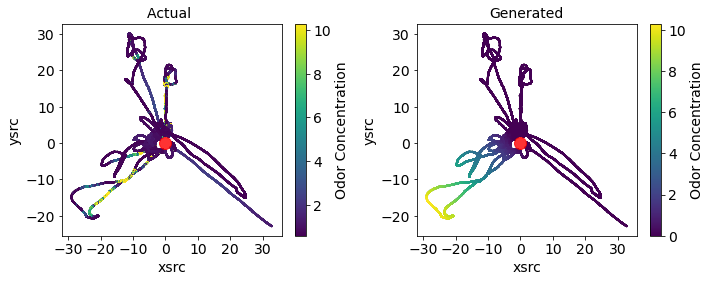

In [95]:
# Get xsrc and ysrc values
xsrc_values = t_data.xsrc.values
ysrc_values = t_data.ysrc.values

f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
# Create a scatter plot
v1 = ax1.scatter(xsrc_values, ysrc_values, c=t_data.odor, cmap='viridis', marker='o',  s=1)
f.colorbar(v1, label='Odor Concentration',ax=ax1)
ax1.set_xlabel('xsrc')
ax1.set_ylabel('ysrc')
ax1.set_title('Actual ')
ax1.plot(0,0,marker='o',  c='#ff0000', markersize=12, alpha=0.8, rasterized=True)
mpl_functions.set_fontsize(ax1,14)


v2 = ax2.scatter(xsrc_values, ysrc_values, c=generated_odor_np, cmap='viridis', marker='o',  s=1)
f.colorbar(v2, label='Odor Concentration',ax=ax2)
ax2.set_xlabel('xsrc')
ax2.set_ylabel('ysrc')
ax2.set_title('Generated')
ax2.plot(0,0,marker='o',  c='#ff0000', markersize=12, alpha=0.8, rasterized=True)
mpl_functions.set_fontsize(ax2,14)


f.tight_layout(pad=1)
f.savefig('../Figure/research2/gan1.jpeg', dpi=300, bbox_inches = "tight")

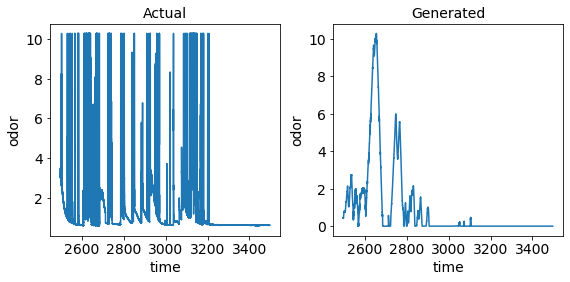

In [98]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
# Create a scatter plot
ax1.plot(t_data.time, t_data.odor)
ax1.set_xlabel('time')
ax1.set_ylabel('odor')
ax1.set_title('Actual')
mpl_functions.set_fontsize(ax1,14)

ax2.plot(t_data.time,x )
ax2.set_xlabel('time')
ax2.set_ylabel('odor')
ax2.set_title('Generated')
mpl_functions.set_fontsize(ax2,14)

f.tight_layout(pad=1)
f.savefig('../Figure/research2/gan221.jpeg', dpi=300, bbox_inches = "tight")

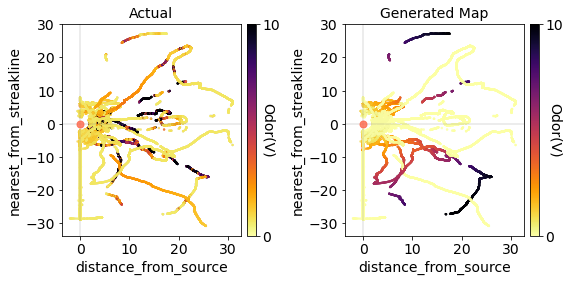

In [103]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
# Create a scatter plot

var = ax1.scatter(t_data.distance_from_source_a*t_data.xsign,
                    t_data.nearest_from_streakline*t_data.ysign,
                    c=t_data.odor, cmap='inferno_r',vmin=0,vmax=10,
           edgecolors='none', s=5,alpha=0.2, rasterized=True )
ax1.grid(False)
ax1.axhline(0, color = 'grey', alpha=1,linewidth=0.3)
ax1.axvline(0, color = 'grey', alpha=1,linewidth=0.3)
ax1.plot(0,0,marker='o',  c='#fd6549ff', markersize=7, alpha=0.8, rasterized=True)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical', ticks=[0, 10])
cbar.ax.set_yticklabels(['0', '10'])
cbar.ax.set_ylabel('Odor(V)', rotation=-90, labelpad=-5)
cbar.solids.set(alpha=1)
ax1.set_xlabel('distance_from_source')
ax1.set_ylabel('nearest_from_streakline')
ax1.set_title('Actual')
mpl_functions.set_fontsize(ax1,14)




var = ax2.scatter(t_data.distance_from_source_a*t_data.xsign,
                    t_data.nearest_from_streakline*t_data.ysign,
                    c=x, cmap='inferno_r',vmin=0,vmax=10,
           edgecolors='none', s=5,alpha=0.2, rasterized=True )
ax2.grid(False)
ax2.axhline(0, color = 'grey', alpha=1,linewidth=0.3)
ax2.axvline(0, color = 'grey', alpha=1,linewidth=0.3)
ax2.plot(0,0,marker='o',  c='#fd6549ff', markersize=7, alpha=0.8, rasterized=True)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical', ticks=[0, 10])
cbar.ax.set_yticklabels(['0', '10'])
cbar.ax.set_ylabel('Odor(V)', rotation=-90, labelpad=-1)
cbar.solids.set(alpha=1)
ax2.set_xlabel('distance_from_source')
ax2.set_ylabel('nearest_from_streakline')
ax2.set_title('Generated Map')
mpl_functions.set_fontsize(ax1,14)

f.tight_layout(pad=1)
f.savefig('../Figure/research2/gan33.jpeg', dpi=300, bbox_inches = "tight")



In [84]:
# q='odor>=4.5'
# t_data=t_data.query(q)